# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Step 1: Data Loading and Exploration

In [19]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv('/Users/rafaeldubach/Quantitative_Trading_Algorithm/output.csv')

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Step 2: Preprocess and Feature Engineering

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Step 3: Custom Train-Test Split for LSTM

In [21]:
# Custom function to split data for each year to keep the data sequential
def custom_train_test_split(features, target, train_size=42, test_size=10):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for start in range(0, len(features), train_size + test_size):
        end_train = start + train_size
        end_test = end_train + test_size
        if end_test <= len(features):
            X_train_list.append(features[start:end_train])
            y_train_list.append(target[start:end_train])
            X_test_list.append(features[end_train:end_test])
            y_test_list.append(target[end_train:end_test])
    
    X_train_lstm_prepared = np.concatenate(X_train_list)
    y_train_lstm_prepared = np.concatenate(y_train_list)
    X_test_lstm_prepared = np.concatenate(X_test_list)
    y_test_lstm_prepared = np.concatenate(y_test_list)
    
    return X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared

# Split the data using the custom function
X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared = custom_train_test_split(features_scaled, target)

# Reshape data for LSTM (needs 3D input)
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))


## Step 4: Model Implementation

### Feed-Forward Neural Network (FFNN)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the FFNN model creation function
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

Epoch 1/50


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3781504.0000 - val_loss: 3836966.2500
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 3647152.5000 - val_loss: 3593186.7500
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 3281044.2500 - val_loss: 2772828.0000
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 2632248.0000 - val_loss: 1458057.3750
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 1237318.2500 - val_loss: 470401.7500
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 451494.7500 - val_loss: 186375.0156
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 246580.9219 - val_loss: 132010.6094
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 205777.2656 - val_loss: 104630.1562
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 193663.1250 - val_loss: 85455.7344
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 159170.5781 - val_loss: 73183.8125
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 600

### Long Short-Term Memory Network (LSTM)

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1371450.7500 - val_loss: 12303266.0000
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1416825.5000 - val_loss: 12299069.0000
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1372103.1250 - val_loss: 12289690.0000
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1371544.2500 - val_loss: 12267324.0000
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1373102.0000 - val_loss: 12216175.0000
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1366999.1250 - val_loss: 12130321.0000
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1365987.8750 - val_loss: 11994763.0000
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1345317.3750 - val_loss: 11815789.0000
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1310428.0000 - val_loss: 11571421.0000
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 1265992.1250 - val_loss: 11283813.0000
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━

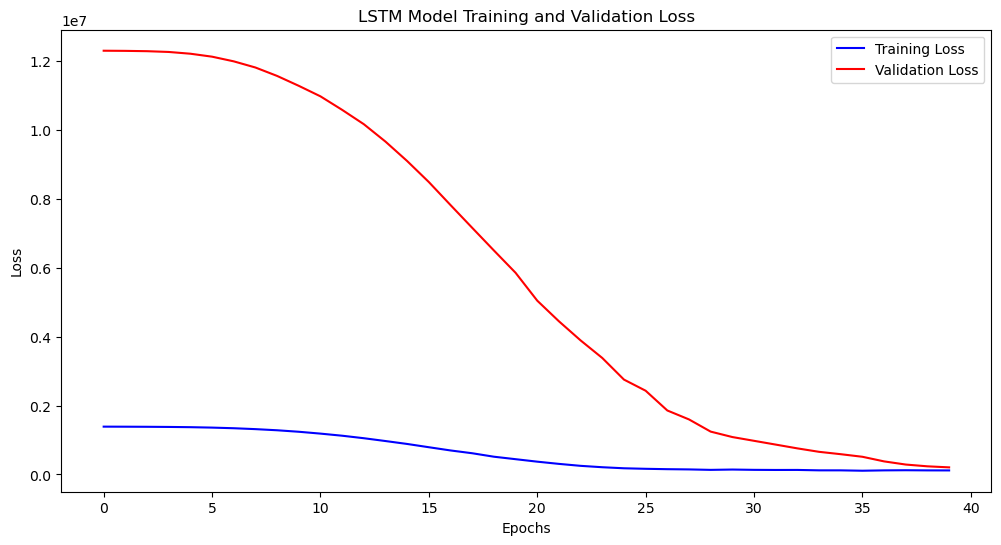

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.src.layers import BatchNormalization
from keras.layers import LSTM
import matplotlib.pyplot as plt


# Reshape data for LSTM (needs 3D input)
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(10, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.5))  # Add dropout for regularization
lstm_model.add(BatchNormalization())  # Add batch normalization
lstm_model.add(Dense(32, activation='relu'))  # Add an additional dense layer
lstm_model.add(Dropout(0.5))  # Add another dropout for regularization
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm_prepared, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

# Evaluate the model on the test set
lstm_evaluation = lstm_model.evaluate(X_test_lstm, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

# Make predictions
lstm_predictions = lstm_model.predict(X_test_lstm)

print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Convolutional Neural Network (CNN)

In [24]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")


Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3313884.0000 - val_loss: 1096775.8750
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1087783.7500 - val_loss: 791106.5625
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 739399.5000 - val_loss: 301819.2188
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 241136.3125 - val_loss: 120115.4062
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106986.6719 - val_loss: 78709.3125
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80372.7109 - val_loss: 52731.0586
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54044.2266 - val_loss: 41051.8867
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43025.2891 - val_loss: 32114.5625
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34806.4922 - val_loss: 29185.0605
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31651.7695 - val_loss: 22049.3887
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27467.9160 - val_lo

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

From here trash code

Dave Evaluation of Strategy:
- [ ] Sharpe Ratio
- [ ] In sample, out sample performance
- [ ] Information Coefficient


Rafael
- [ ] Use Multiple Sets of Signals

Felix
- [ ] Write shit
- [ ] Hyperparameter Tuning (Optional)

After:
- [ ] Hyperparameter Tuning
- [ ] Data Augmentation


## Step 5: Backtest and Evaluate the Strategy

In [25]:
import numpy as np

# Define a simple trading strategy
def trading_strategy(predictions, actual_prices):
    # Align the lengths by dropping the last element of the predictions array to match actual_prices
    predictions = predictions[:-1]
    actual_prices = actual_prices[:-1]
    
    # Create signals: 1 for buy, -1 for sell
    signals = np.where(predictions > actual_prices, 1, -1)
    
    # Calculate returns based on signals
    aligned_actual_prices = actual_prices[1:]  # Align for the same shape
    returns = signals[:-1] * (aligned_actual_prices - actual_prices[:-1])
    return returns

# Backtest the strategy with FFNN predictions
ffnn_returns = trading_strategy(ffnn_predictions.flatten(), y_test.values)
ffnn_sharpe_ratio = np.mean(ffnn_returns) / np.std(ffnn_returns) * np.sqrt(252)  # Annualized Sharpe ratio

print(f"FFNN Trading Strategy Sharpe Ratio: {ffnn_sharpe_ratio}")

# Backtest with LSTM predictions
lstm_returns = trading_strategy(lstm_predictions.flatten(), y_test_lstm_prepared)
lstm_sharpe_ratio = np.mean(lstm_returns) / np.std(lstm_returns) * np.sqrt(252)

print(f"LSTM Trading Strategy Sharpe Ratio: {lstm_sharpe_ratio}")

# Backtest with CNN predictions
cnn_returns = trading_strategy(cnn_predictions.flatten(), y_test.values)
cnn_sharpe_ratio = np.mean(cnn_returns) / np.std(cnn_returns) * np.sqrt(252)

print(f"CNN Trading Strategy Sharpe Ratio: {cnn_sharpe_ratio}")

print("Backtesting and Evaluation Complete.")


FFNN Trading Strategy Sharpe Ratio: 2.1508329514669553
LSTM Trading Strategy Sharpe Ratio: -0.07782661688094998
CNN Trading Strategy Sharpe Ratio: 0.11299423163752363
Backtesting and Evaluation Complete.


## Step 5: Calculate Model Accuracy

### Step 1: Calculate Model Accuracy
We will evaluate the model's accuracy using metrics such as Mean Squared Error (MSE) and R-squared.

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print model accuracy for FFNN
ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_r2 = r2_score(y_test, ffnn_predictions)
print(f"FFNN Model MSE: {ffnn_mse}")
print(f"FFNN Model R-squared: {ffnn_r2}")

# Calculate and print model accuracy for LSTM
lstm_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)
lstm_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
print(f"LSTM Model MSE: {lstm_mse}")
print(f"LSTM Model R-squared: {lstm_r2}")

# Calculate and print model accuracy for CNN
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)
print(f"CNN Model MSE: {cnn_mse}")
print(f"CNN Model R-squared: {cnn_r2}")


FFNN Model MSE: 16059.507400591017
FFNN Model R-squared: 0.9891642064762406
LSTM Model MSE: 71788.2805409972
LSTM Model R-squared: 0.9499192706657222
CNN Model MSE: 6534.400059737416
CNN Model R-squared: 0.995591059670588


### Step 2: Show and Discuss Results
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

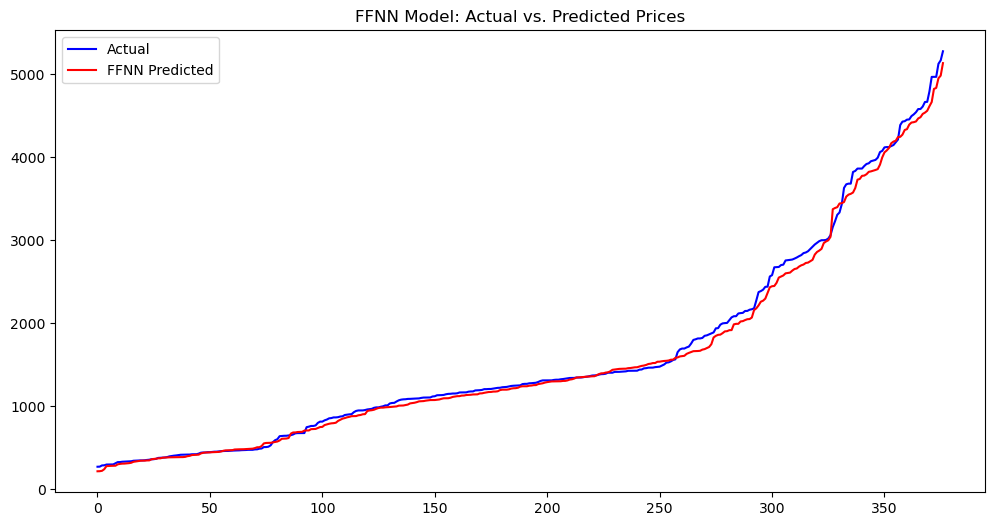

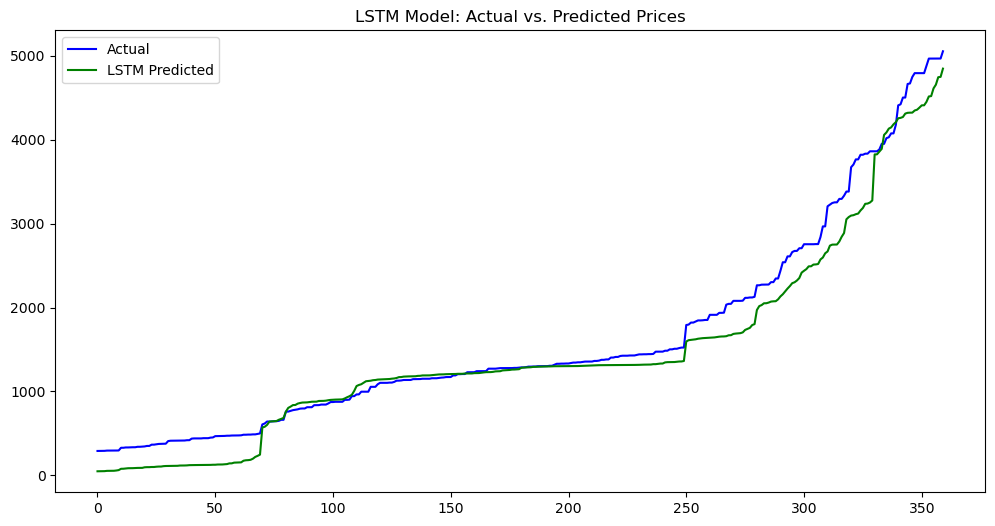

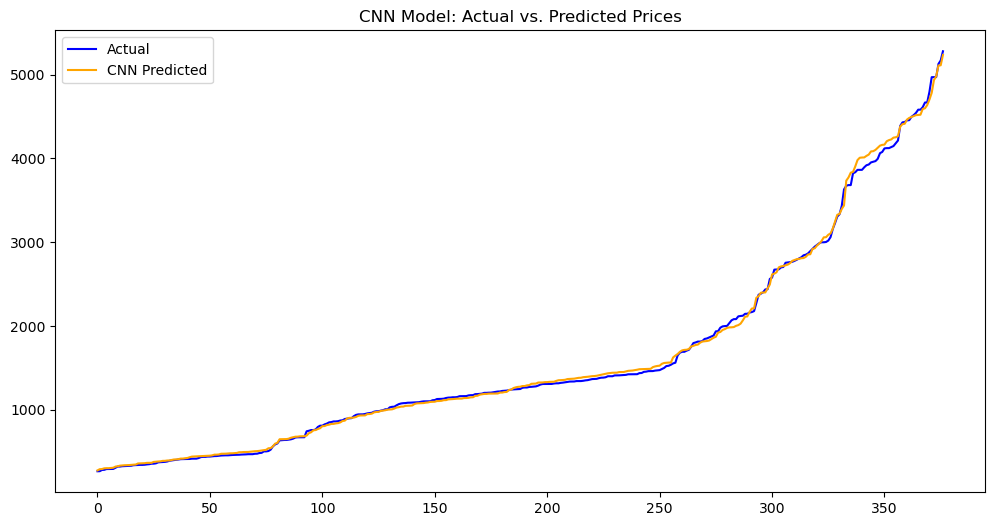

In [27]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()


# DAVE TILL HERE

# RAFAEL FROM HERE

### Step 3: Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3593957.5000 - val_loss: 3822646.5000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 3673178.0000 - val_loss: 3780411.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 3461187.0000 - val_loss: 3649367.2500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 3285340.7500 - val_loss: 3377699.7500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 3192097.7500 - val_loss: 2962146.0000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - loss: 2576357.0000 - val_loss: 2476635.5000
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 2436749.7500 - val_loss: 2065060.3750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 1956807.0000 - val_loss: 1799512.2500
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1861668.3750 - val_loss: 1658059.1250
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1583419.2500 - val_loss: 1569639.1250
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━

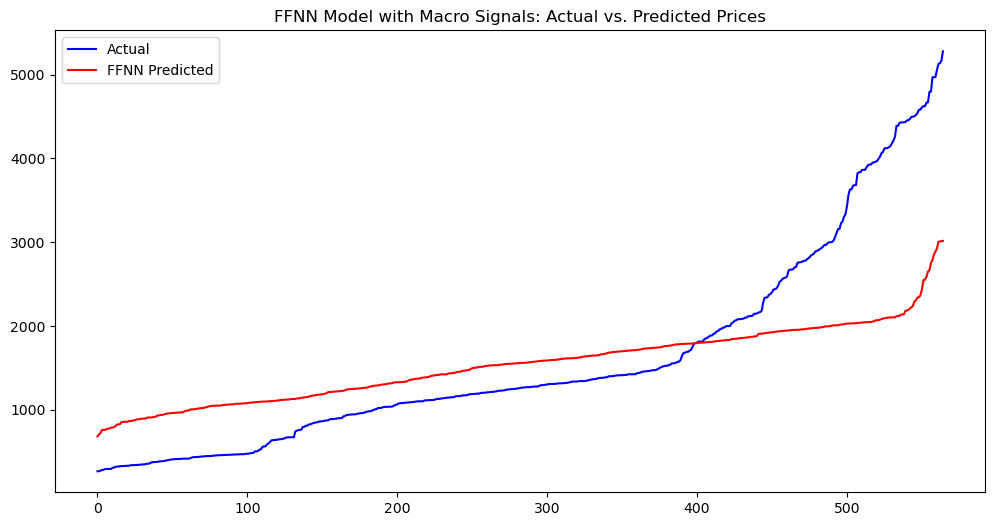

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3767721.0000 - val_loss: 3814101.5000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 3719524.5000 - val_loss: 3705597.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 3460361.7500 - val_loss: 3381068.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 3003011.2500 - val_loss: 2766951.7500
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 2616470.2500 - val_loss: 1965412.7500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1715300.3750 - val_loss: 1198327.1250
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1138816.3750 - val_loss: 704379.7500
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 723914.9375 - val_loss: 474914.8750
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 574872.9375 - val_loss: 373594.8125
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 433921.8750 - val_loss: 317989.4375
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6

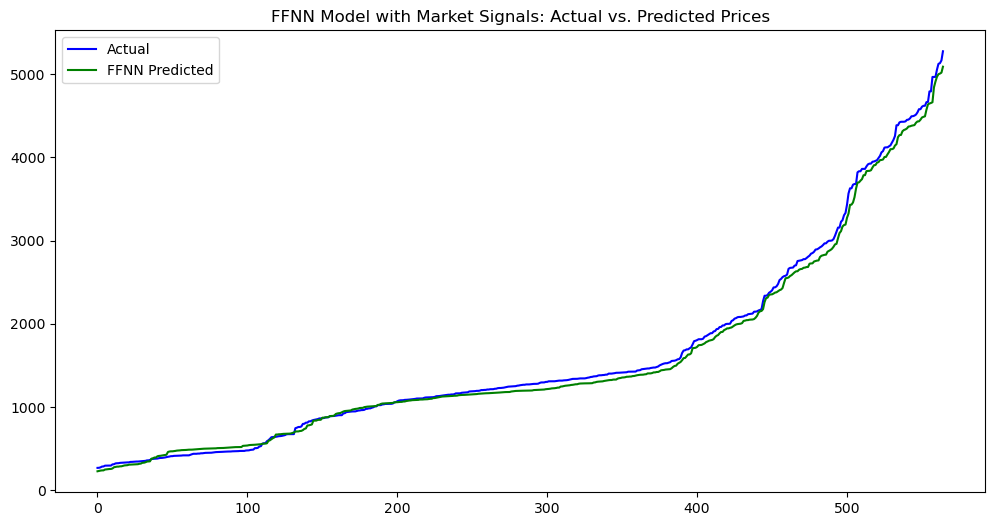

In [28]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(sorted(y_test_macro), ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(sorted(y_test_macro), ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_macro_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(sorted(y_test_market), ffnn_market_predictions)
ffnn_market_r2 = r2_score(sorted(y_test_market), ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_market_predictions.flatten()), label='FFNN Predicted', color='green')
plt.title('FFNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# LSTM

In [29]:
# TODO

# CNN

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3961124.7500 - val_loss: 3467441.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2702950.2500 - val_loss: 1416545.3750
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1586607.3750 - val_loss: 1378246.6250
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1410743.0000 - val_loss: 1319604.1250
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1320862.6250 - val_loss: 1272052.0000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1366669.7500 - val_loss: 1233981.2500
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1290954.3750 - val_loss: 1223469.8750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1342576.3750 - val_loss: 1222543.0000
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1163222.5000 - val_loss: 1169317.1250
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1251840.7500 - val_loss: 1136261.5000
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

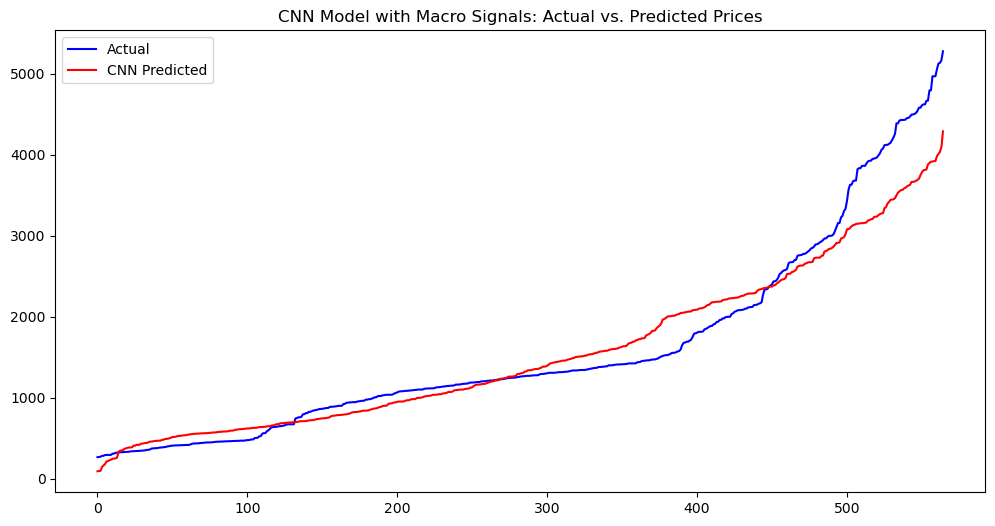

Epoch 1/40


/Users/rafaeldubach/miniconda3/envs/DL/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3630909.0000 - val_loss: 3345110.7500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2678126.0000 - val_loss: 627567.8750
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 613374.9375 - val_loss: 428333.0625
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 430457.2812 - val_loss: 217572.5938
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 212917.8750 - val_loss: 73973.5312
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74088.2031 - val_loss: 27091.4160
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31217.0508 - val_loss: 20834.7910
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26161.2148 - val_loss: 18420.6445
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25845.3105 - val_loss: 16154.9561
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23425.5898 - val_loss: 14614.2969
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22267.0645 - val_lo

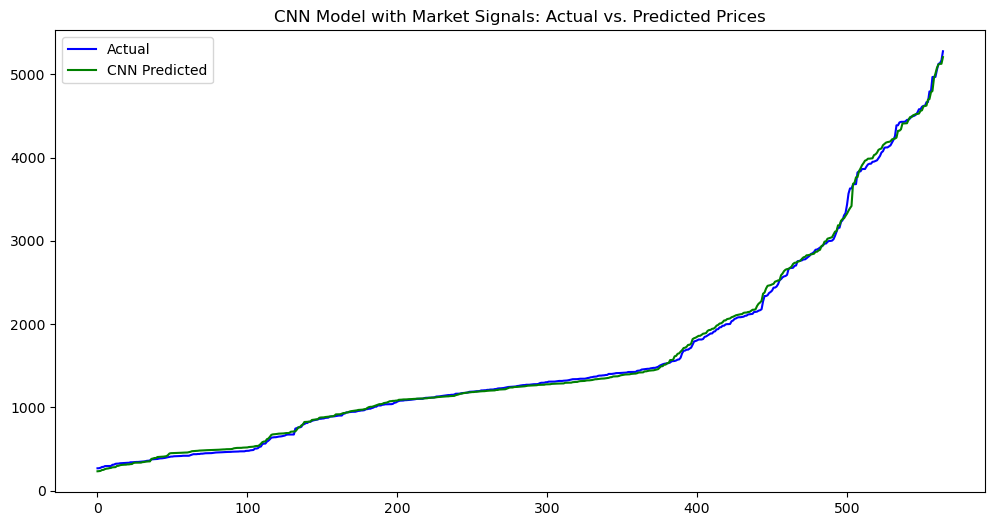

In [30]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)
cnn_macro_mse = mean_squared_error(sorted(y_test_macro), cnn_macro_predictions)
cnn_macro_r2 = r2_score(sorted(y_test_macro), cnn_macro_predictions)
print(f"CNN with Macro Signals MSE: {cnn_macro_mse}")
print(f"CNN with Macro Signals R-squared: {cnn_macro_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_macro.values), label='Actual', color='blue')
plt.plot(sorted(cnn_macro_predictions.flatten()), label='CNN Predicted', color='red')
plt.title('CNN Model with Macro Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)
cnn_market_mse = mean_squared_error(sorted(y_test_market), cnn_market_predictions)
cnn_market_r2 = r2_score(sorted(y_test_market), cnn_market_predictions)
print(f"CNN with Market Signals MSE: {cnn_market_mse}")
print(f"CNN with Market Signals R-squared: {cnn_market_r2}")

plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_market.values), label='Actual', color='blue')
plt.plot(sorted(cnn_market_predictions.flatten()), label='CNN Predicted', color='green')
plt.title('CNN Model with Market Signals: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# DAVE AB HIER WIEDER

### Step 4: In-sample and Out-of-sample Performance
In-sample Predictions and Plotting:

Evaluate the in-sample performance using training data.
Compare the in-sample predictions to the actual values.
Plot the actual vs. predicted values for in-sample data.

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
FFNN In-sample MSE: 3697.2311162918245
FFNN In-sample R-squared: 0.9971540213980667


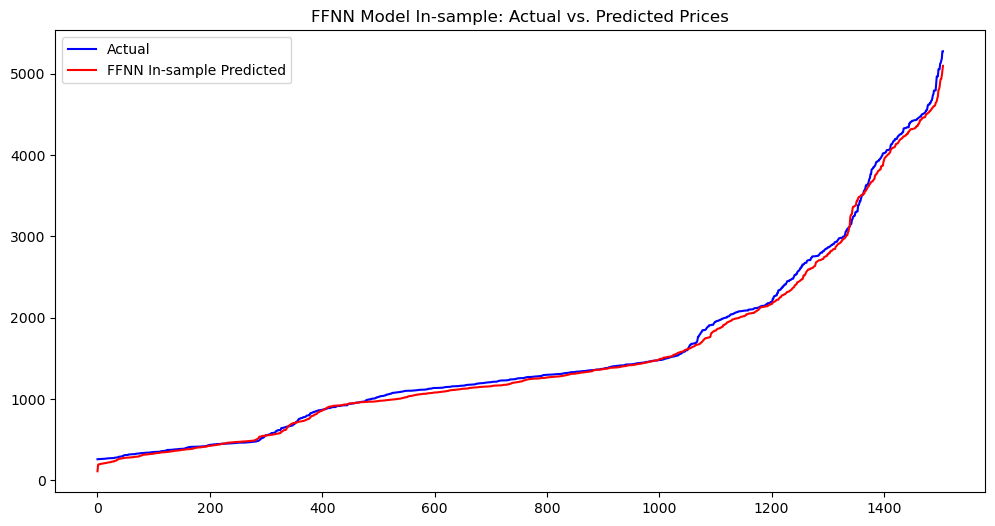

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
LSTM In-sample MSE: 51031.624402393405
LSTM In-sample R-squared: 0.9583994798223838


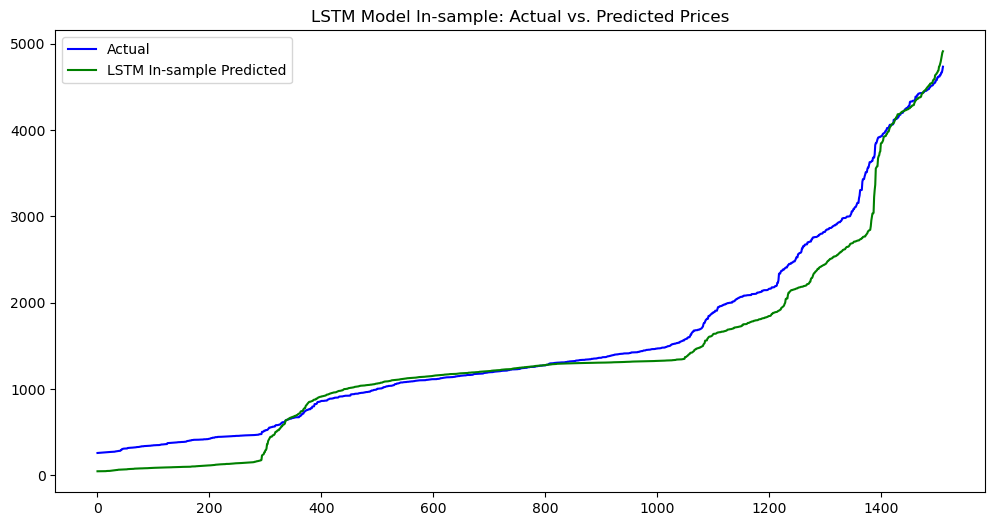

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
CNN In-sample MSE: 6232227.582645449
CNN In-sample R-squared: -3.79731609539642


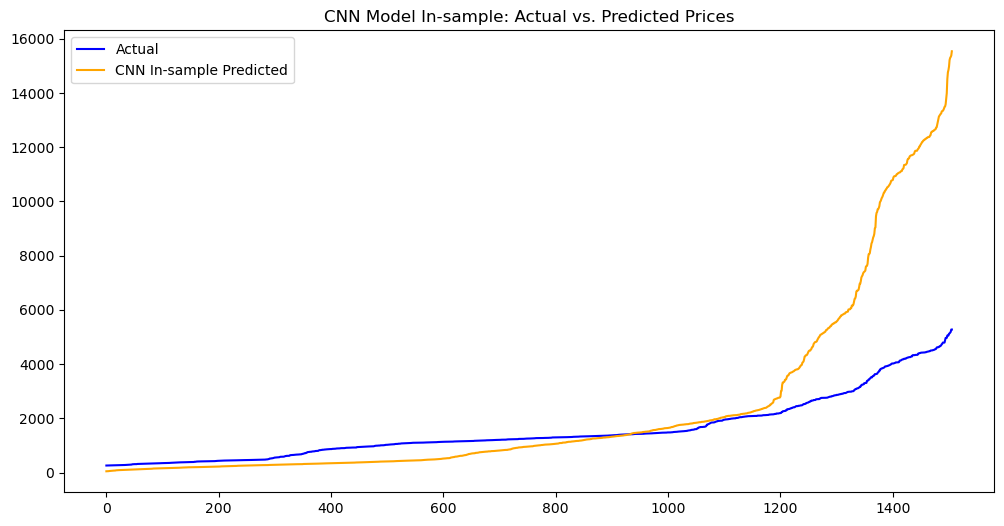

In [31]:
# In-sample predictions for FFNN
ffnn_in_sample_predictions = ffnn_model.predict(X_train)
ffnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(ffnn_in_sample_predictions))
ffnn_in_sample_r2 = r2_score(sorted(y_train), sorted(ffnn_in_sample_predictions))
print(f"FFNN In-sample MSE: {ffnn_in_sample_mse}")
print(f"FFNN In-sample R-squared: {ffnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (FFNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_in_sample_predictions.flatten()), label='FFNN In-sample Predicted', color='red')
plt.title('FFNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for LSTM
lstm_in_sample_predictions = lstm_model.predict(X_train_lstm)
lstm_in_sample_mse = mean_squared_error(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
lstm_in_sample_r2 = r2_score(sorted(y_train_lstm_prepared), sorted(lstm_in_sample_predictions))
print(f"LSTM In-sample MSE: {lstm_in_sample_mse}")
print(f"LSTM In-sample R-squared: {lstm_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_in_sample_predictions.flatten()), label='LSTM In-sample Predicted', color='green')
plt.title('LSTM Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# In-sample predictions for CNN
cnn_in_sample_predictions = cnn_model.predict(X_train)
cnn_in_sample_mse = mean_squared_error(sorted(y_train), sorted(cnn_in_sample_predictions))
cnn_in_sample_r2 = r2_score(sorted(y_train), sorted(cnn_in_sample_predictions))
print(f"CNN In-sample MSE: {cnn_in_sample_mse}")
print(f"CNN In-sample R-squared: {cnn_in_sample_r2}")

# Plot actual vs. predicted values for in-sample data (CNN)
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_train.values), label='Actual', color='blue')
plt.plot(sorted(cnn_in_sample_predictions.flatten()), label='CNN In-sample Predicted', color='orange')
plt.title('CNN Model In-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()


Out-of-sample Predictions and Plotting:

Evaluate the out-of-sample performance using testing data (already calculated).
Compare the out-of-sample predictions to the actual values.
Plot the actual vs. predicted values for out-of-sample data.

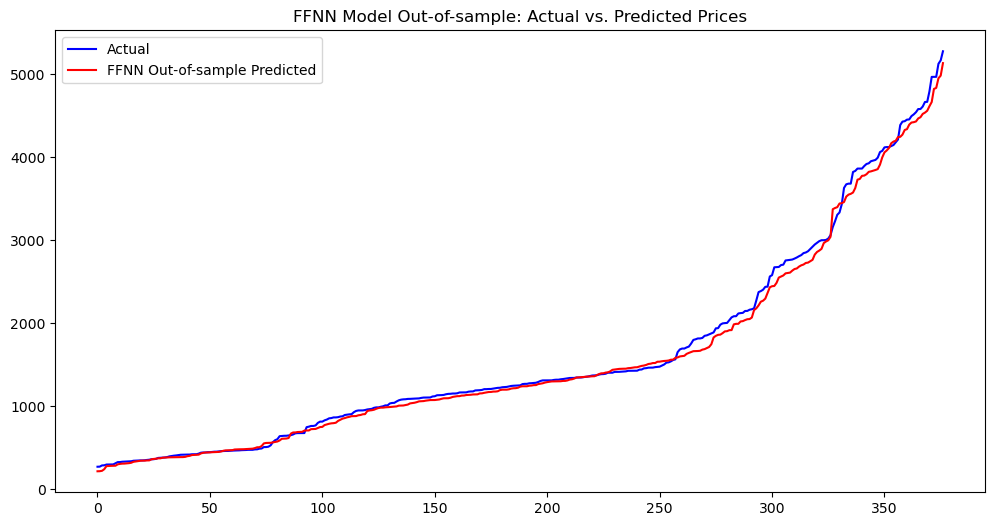

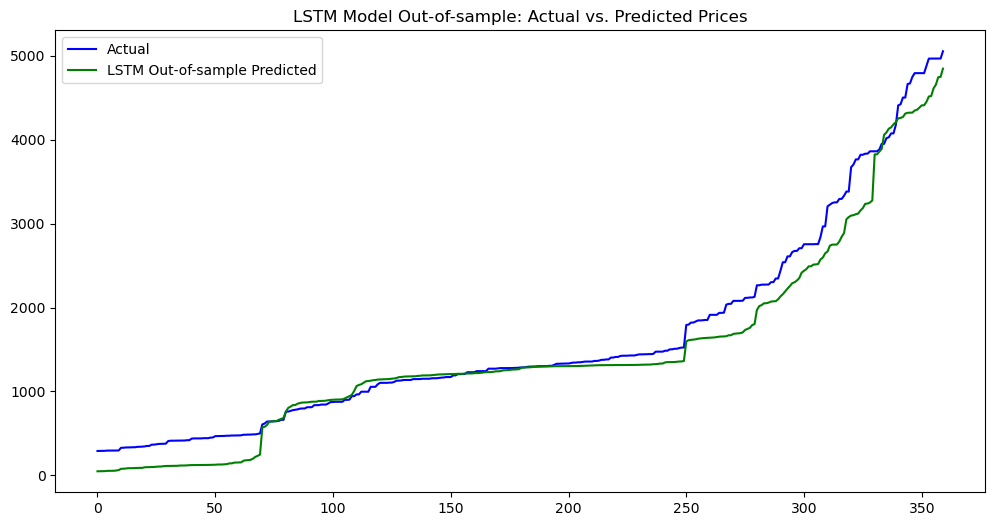

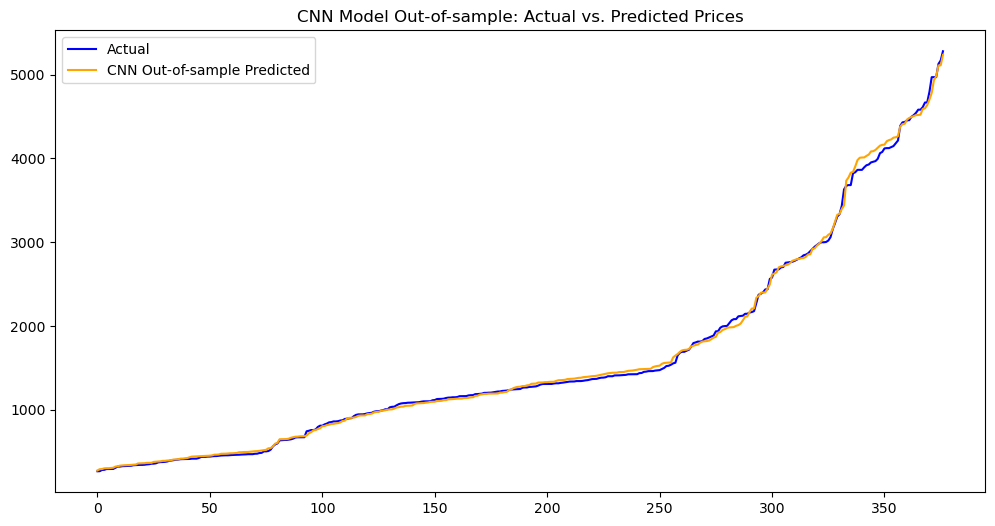

In [32]:
# Out-of-sample predictions for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Out-of-sample Predicted', color='red')
plt.title('FFNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Out-of-sample Predicted', color='green')
plt.title('LSTM Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Out-of-sample predictions for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Out-of-sample Predicted', color='orange')
plt.title('CNN Model Out-of-sample: Actual vs. Predicted Prices')
plt.legend()
plt.show()

### Step 5: Analyze Hypotheses and Results
We will form hypotheses based on our two sets of signals and compare the results to these expectations.

Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

In [33]:
# Evaluate FFNN with macro signals
ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)
ffnn_macro_mse = mean_squared_error(y_test_macro, ffnn_macro_predictions)
ffnn_macro_r2 = r2_score(y_test_macro, ffnn_macro_predictions)
print(f"FFNN with Macro Signals MSE: {ffnn_macro_mse}")
print(f"FFNN with Macro Signals R-squared: {ffnn_macro_r2}")

# Evaluate FFNN with market signals
ffnn_market_predictions = ffnn_model_market.predict(X_test_market)
ffnn_market_mse = mean_squared_error(y_test_market, ffnn_market_predictions)
ffnn_market_r2 = r2_score(y_test_market, ffnn_market_predictions)
print(f"FFNN with Market Signals MSE: {ffnn_market_mse}")
print(f"FFNN with Market Signals R-squared: {ffnn_market_r2}")

# Compare in-sample and out-of-sample performance
print(f"In-sample R-squared: {ffnn_in_sample_r2}")
print(f"Out-of-sample R-squared: {ffnn_r2}")

# Discuss whether the results support the initial hypotheses
if ffnn_macro_r2 > ffnn_market_r2:
    print("Macroeconomic signals provided better predictive power.")
else:
    print("Market and technical signals provided better predictive power.")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
FFNN with Macro Signals MSE: 891277.2119838179
FFNN with Macro Signals R-squared: 0.37310623548065935
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step
FFNN with Market Signals MSE: 12866.719038202355
FFNN with Market Signals R-squared: 0.990949991959384
In-sample R-squared: 0.9971540213980667
Out-of-sample R-squared: 0.9891642064762406
Market and technical signals provided better predictive power.


### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!